# Importamos las librerias

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
import os

In [2]:
EPOCHS = 25
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 3
Image_Size = (IMG_HEIGHT, IMG_WIDTH)

# Activamos la GPU

# Definimos las constantes

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

# Lectura del dataset

In [4]:
def read_directory(path):
    
    labels = []
    images = []
    
    for root, dirs, files in os.walk(path):

        for name in dirs:
            
            direct = os.path.join(path, name)
            
            for filename in os.listdir(direct):
                
                img = cv.imread(os.path.join(path + "/" + name, filename))
                img = cv.resize(img, Image_Size)
                images.append(img)
                labels.append(name)
                
    return images, labels

In [5]:
path = './tanks/train/'
train_images, train_labels = read_directory(path)

In [6]:
path = './tanks/test/'
test_images, test_labels = read_directory(path)

# Visualizacion de datos

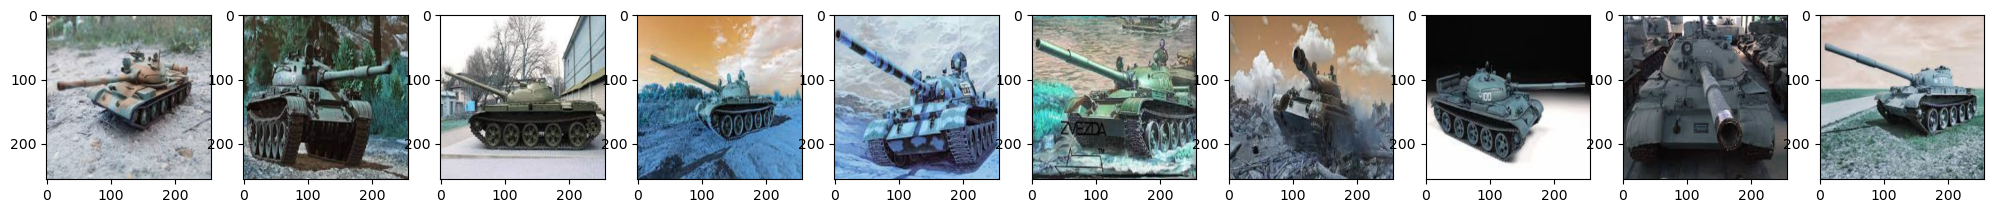

In [7]:
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(train_images[i])

In [8]:
train_labels

['t-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-62',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-64',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 't-72',
 

# Preprocesing dataset

In [9]:
imagenes_bn = []
for imagen in train_images:
    imagen_bn = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)  # Convertir de BGR a escala de grises
    imagen_bn = cv.cvtColor(imagen_bn, cv.COLOR_GRAY2RGB) # crear capas adicionales 
    imagenes_bn.append(imagen_bn)
    
#train_images = imagenes_bn

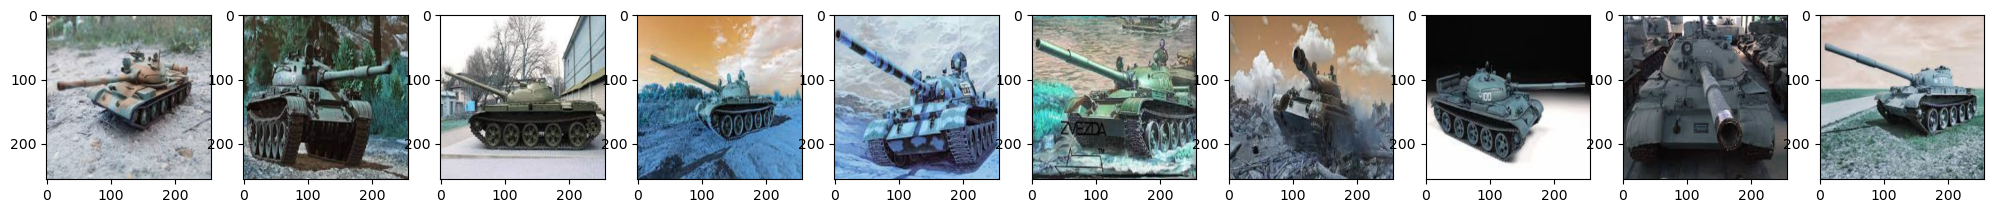

In [10]:
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(train_images[i])

In [11]:
train_images = np.array(train_images)
train_images = train_images.astype('float32')
train_images = train_images /255.0
#X = X.reshape(-1,300,200,1)
#y= np.array(pd.get_dummies(pd.DataFrame(y),columns=[0]))
encoder = OneHotEncoder(sparse_output=False)
train_labels_2d = [[label] for label in train_labels]
train_labels = encoder.fit_transform(train_labels_2d)

train_images.shape, train_labels.shape

((240, 256, 256, 3), (240, 5))

In [12]:
imagenes_bn = []
for imagen in test_images:
    imagen_bn = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)  # Convertir de BGR a escala de grises
    imagen_bn = cv.cvtColor(imagen_bn, cv.COLOR_GRAY2RGB) # crear capas adicionales
    imagenes_bn.append(imagen_bn)
    
test_images = imagenes_bn

In [13]:
test_images = np.array(test_images)
test_images = test_images.astype('float32')
test_images = test_images /255.0
#X = X.reshape(-1,300,200,1)
#y= np.array(pd.get_dummies(pd.DataFrame(y),columns=[0]))
encoder = OneHotEncoder(sparse_output=False)
test_labels_2d = [[label] for label in test_labels]
test_labels = encoder.fit_transform(test_labels_2d)

test_images.shape, test_labels.shape

((60, 256, 256, 3), (60, 5))

# Aumento de imagenes

In [14]:
# Crear un array vacío para almacenar las imágenes aumentadas
augmented_images = []
augmented_labels = []

for i, image in enumerate(train_images):
    # Aplicar las transformaciones de aumento de datos a cada imagen

    # Rotación
    M = cv.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), 20, 1)
    rotated_image = cv.warpAffine(image, M, (image.shape[1], image.shape[0]))
    rotated_image = cv.resize(rotated_image, Image_Size)
    
    # Rotación inversa
    N = cv.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), -20, 1)
    inverse_rotated_image = cv.warpAffine(image, N, (image.shape[1], image.shape[0]))
    inverse_rotated_image = cv.resize(inverse_rotated_image, Image_Size)

    # Volteo horizontal
    flipped_image = cv.flip(image, 1)
    flipped_image = cv.resize(flipped_image, Image_Size)
    
    # Blanco y negro
    imagen_bn = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convertir de BGR a escala de grises
    imagen_bn = cv.cvtColor(imagen_bn, cv.COLOR_GRAY2RGB) # crear capas adicionales


    # Agregar las imágenes aumentadas al array 'augmented_images'
    
    #augmented_images.append(rotated_image)
    #augmented_labels.append(train_labels[i])
    
    #augmented_images.append(inverse_rotated_image)
    #augmented_labels.append(labels_train[i])
    
    augmented_images.append(flipped_image)
    augmented_labels.append(train_labels[i])
    
    augmented_images.append(imagen_bn)
    augmented_labels.append(train_labels[i])

# Convertir el array 'augmented_images' en un array de NumPy
augmented_images = np.array(augmented_images)

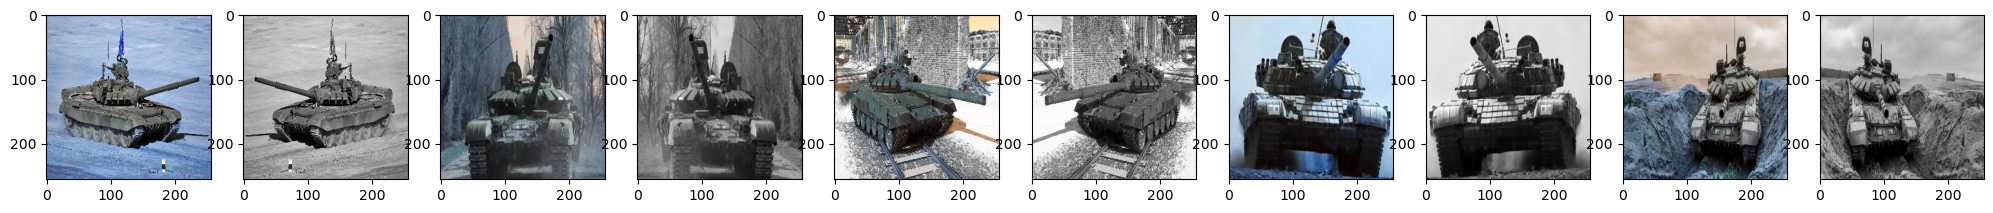

In [15]:
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(augmented_images[i+200])

In [16]:
#train_images = np.vstack((train_images, augmented_images))
#train_labels = np.vstack((train_labels, augmented_labels))

In [17]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((240, 256, 256, 3), (60, 256, 256, 3), (240, 5), (60, 5))

# Creacion del modelo

In [18]:
CATEGORIES = train_labels.shape[1]

In [19]:
from tensorflow.keras.applications import DenseNet121

def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    
    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.45),
        
        tf.keras.layers.Dense(CATEGORIES, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
class CustomEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def on_epoch_end(self, epoch, logs=None):
        current_patience = self.patience - epoch // 10  # Disminuye la paciencia de forma de forma gradual 
        current_patience = max(current_patience, 5)  # Asegura que la paciencia no sea un número negativo
        self.patience = current_patience
        super().on_epoch_end(epoch, logs)

# Definir la configuración de la regularización temprana
early_stopping = CustomEarlyStopping(
    monitor='val_loss',     # Monitorizar la pérdida en el conjunto de validación
    patience=25,             # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del modelo con la mejor puntuación de validación
)

In [21]:
model = build_model()
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, shuffle=True, validation_data=(test_images,test_labels), callbacks=[early_stopping], verbose = 1)

Epoch 1/25
8/8 [==============================] - 34s 4s/step - loss: 2.2834 - accuracy: 0.2500 - val_loss: 1.2274 - val_accuracy: 0.4833
Epoch 2/25
8/8 [==============================] - 24s 3s/step - loss: 1.4475 - accuracy: 0.4458 - val_loss: 1.3733 - val_accuracy: 0.3500
Epoch 3/25
8/8 [==============================] - 25s 3s/step - loss: 1.0314 - accuracy: 0.6000 - val_loss: 1.1327 - val_accuracy: 0.6167
Epoch 4/25
8/8 [==============================] - 25s 3s/step - loss: 0.8247 - accuracy: 0.6958 - val_loss: 1.0732 - val_accuracy: 0.4667
Epoch 5/25
8/8 [==============================] - 29s 4s/step - loss: 0.6543 - accuracy: 0.7833 - val_loss: 0.9950 - val_accuracy: 0.6167
Epoch 6/25
8/8 [==============================] - 28s 4s/step - loss: 0.6011 - accuracy: 0.7792 - val_loss: 1.0010 - val_accuracy: 0.6500
Epoch 7/25
8/8 [==============================] - 29s 4s/step - loss: 0.4926 - accuracy: 0.8208 - val_loss: 0.8269 - val_accuracy: 0.7000
Epoch 8/25
8/8 [==================

In [22]:
model.evaluate(test_images, test_labels)

2/2 [==============================] - 6s 3s/step - loss: 0.7602 - accuracy: 0.7667


[0.7601867914199829, 0.7666666507720947]

# Visualizacion de los resultados

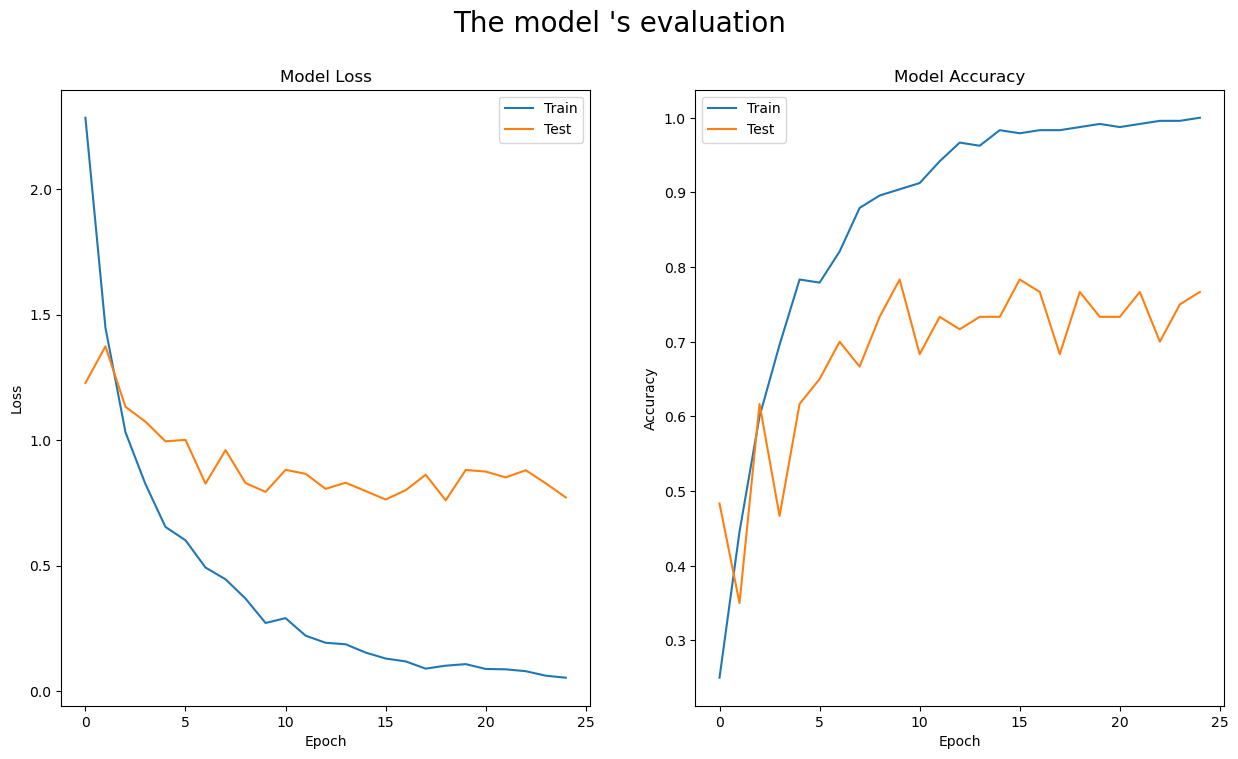

In [23]:
fig,axes = plt.subplots(1,2, figsize=(15,8))
fig.suptitle("The model 's evaluation ",fontsize=20)
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train','Test'])


axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train','Test'])
plt.show()

In [24]:
prediction = model.predict(test_images)

2/2 [==============================] - 8s 3s/step


In [25]:
real = test_labels.astype('int')
real = real.argmax(axis=1)

max = prediction.max(axis=1).reshape(-1, 1)
predictionReshaped = np.where(prediction == max, 1, 0)
predictionReshaped = predictionReshaped.argmax(axis=1)

categories = ["t-62",'t-64','t-72','t-80','t-90']

In [26]:
data = {'Categoría': categories,
        'Datos Clasificados': np.bincount(predictionReshaped, minlength=CATEGORIES)[0:CATEGORIES],
        'Datos Reales': np.bincount(real, minlength=CATEGORIES)[0:CATEGORIES]}
df = pd.DataFrame(data)

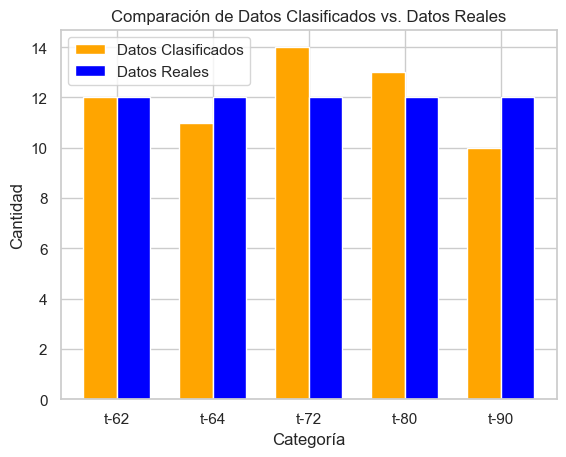

In [27]:
# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Define el ancho de las barras y la separación entre las categorías
bar_width = 0.35
bar_positions = np.arange(len(categories))

# Crea el gráfico de barras para los datos clasificados
plt.bar(bar_positions, df['Datos Clasificados'], color='orange', label='Datos Clasificados', width=bar_width)

# Crea el gráfico de barras para los datos reales desplazado hacia la derecha
plt.bar(bar_positions + bar_width, df['Datos Reales'], color='blue', label='Datos Reales', width=bar_width)

# Configura los ejes y las etiquetas
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.title('Comparación de Datos Clasificados vs. Datos Reales')
plt.xticks(bar_positions + bar_width / 2, categories)
plt.legend()

# Muestra el gráfico
plt.show()

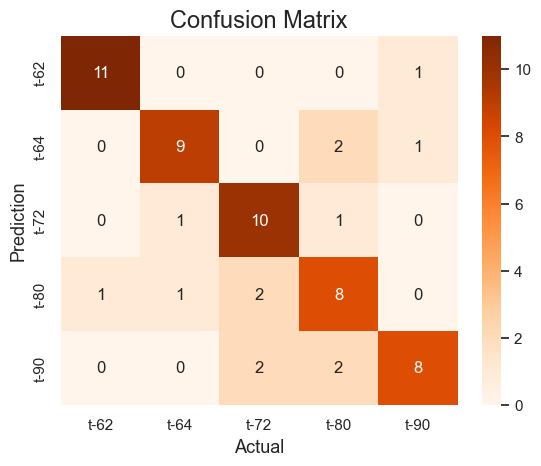

In [28]:
confusion_matrix = metrics.confusion_matrix(real, predictionReshaped)

sns.heatmap(confusion_matrix,
            annot=True,
            fmt='g',
            xticklabels=categories,
            yticklabels=categories,
            cmap='Oranges'
    )

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [29]:
def highlight_max(s):
    '''
    highlight the maximum in a Series orange.
    '''
    is_max = s == s.max()
    return ['background-color: orange' if v else '' for v in is_max]

In [30]:
#datos predichos

predictionHighlight = pd.DataFrame(prediction).T.style.apply(highlight_max)

predictionHighlight

In [31]:
#datos reales

realOneHotEncoder = pd.DataFrame(test_labels).T

realOneHotEncoder['type'] = categories

realHighligh = realOneHotEncoder.set_index('type').style.apply(highlight_max)

realHighligh

# Prediccion de los vehiculos perdidos

In [32]:
path = './tanks/valid/'
valid_images, valid_labels = read_directory(path)

In [33]:
imagenes_bn = []
for imagen in valid_images:
    imagen_bn = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)  # Convertir de BGR a escala de grises
    imagen_bn = cv.cvtColor(imagen_bn, cv.COLOR_GRAY2RGB) # crear capas adicionales
    imagenes_bn.append(imagen_bn)
    
valid_images = imagenes_bn

In [34]:
valid_images = np.array(valid_images)
valid_images = valid_images.astype('float32')
valid_images = valid_images /255.0

encoder = OneHotEncoder(sparse_output=False)
valid_labels_2d = [[label] for label in valid_labels]
valid_labels = encoder.fit_transform(valid_labels_2d)

valid_images.shape, valid_labels.shape

((1145, 256, 256, 3), (1145, 5))

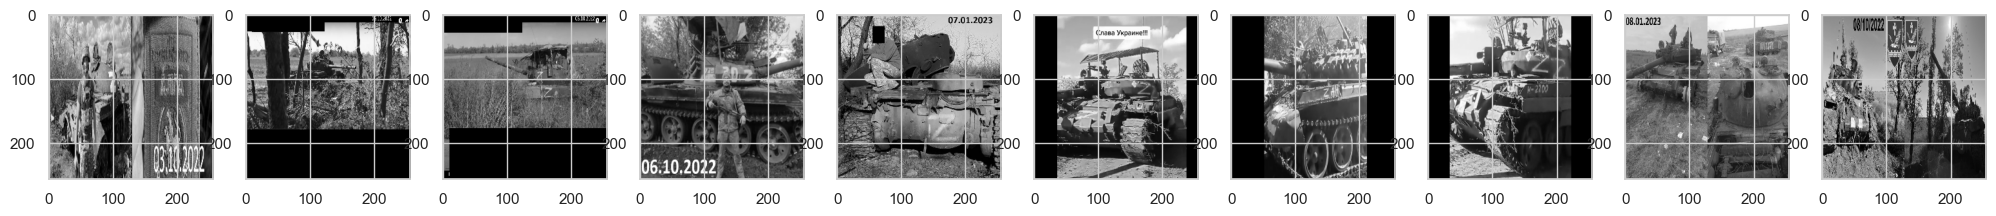

In [35]:
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(valid_images[i])

In [36]:
model.evaluate(valid_images, valid_labels)

36/36 [==============================] - 107s 3s/step - loss: 1.5507 - accuracy: 0.4777


[1.5506703853607178, 0.47772926092147827]

In [37]:
prediction_destroyed_vehicles = model.predict(valid_images)

36/36 [==============================] - 114s 3s/step


In [38]:
real = valid_labels.astype('int')
real = real.argmax(axis=1)

max = prediction_destroyed_vehicles.max(axis=1).reshape(-1, 1)
predictionReshaped = np.where(prediction_destroyed_vehicles == max, 1, 0)
predictionReshaped = predictionReshaped.argmax(axis=1)

In [39]:
data = {'Categoría': categories,
        'Datos Clasificados': np.bincount(predictionReshaped, minlength=CATEGORIES)[0:CATEGORIES],
        'Datos Reales': np.bincount(real, minlength=CATEGORIES)[0:CATEGORIES]}
df = pd.DataFrame(data)

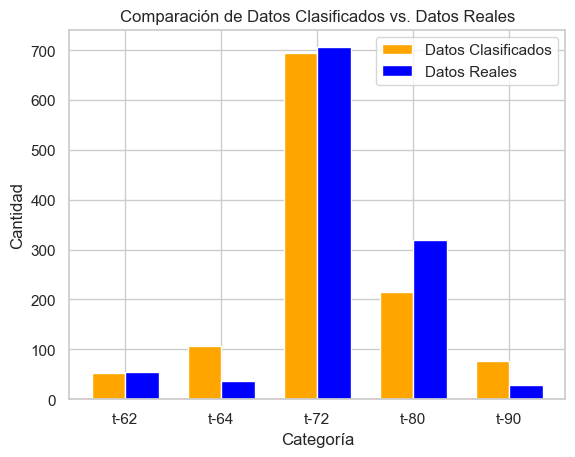

In [40]:
# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Define el ancho de las barras y la separación entre las categorías
bar_width = 0.35
bar_positions = np.arange(len(categories))

# Crea el gráfico de barras para los datos clasificados
plt.bar(bar_positions, df['Datos Clasificados'], color='orange', label='Datos Clasificados', width=bar_width)

# Crea el gráfico de barras para los datos reales desplazado hacia la derecha
plt.bar(bar_positions + bar_width, df['Datos Reales'], color='blue', label='Datos Reales', width=bar_width)

# Configura los ejes y las etiquetas
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.title('Comparación de Datos Clasificados vs. Datos Reales')
plt.xticks(bar_positions + bar_width / 2, categories)
plt.legend()

# Muestra el gráfico
plt.show()

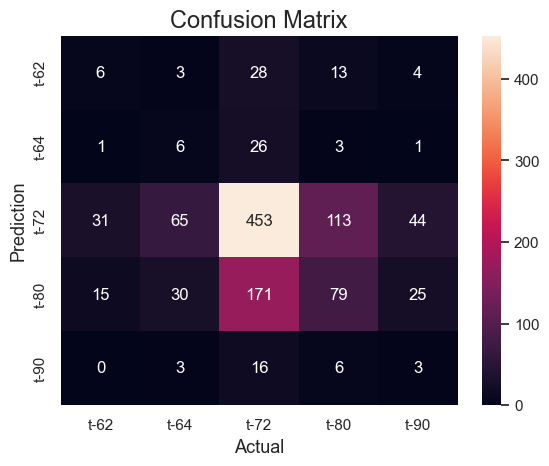

In [41]:
confusion_matrix = metrics.confusion_matrix(real, predictionReshaped)

sns.heatmap(confusion_matrix,
            annot=True,
            fmt='g',
            xticklabels=categories,
            yticklabels=categories,
    )

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [42]:
#datos predichos

predictionHighlight = pd.DataFrame(prediction_destroyed_vehicles).T.style.apply(highlight_max)

predictionHighlight

In [43]:
#datos reales

realOneHotEncoder = pd.DataFrame(valid_labels).T

realOneHotEncoder['type'] = categories

realHighligh = realOneHotEncoder.set_index('type').style.apply(highlight_max)

realHighligh

# Costes de los vehiculos perdidos

In [44]:
conteo = np.bincount(predictionReshaped)
perdidas = pd.DataFrame({'Tipo': categories, 'Cantidad de perdidas': conteo})

In [45]:
coste_por_unidad = pd.read_csv('./tanks/cost.csv', header=None, sep=';', names=['Tipo', 'Precio por unidad (en millones de dolares)'])

In [46]:
perdidas = pd.merge(perdidas, coste_por_unidad, on='Tipo')

In [47]:
perdidas['Coste total (en millones de dolares)'] = perdidas['Cantidad de perdidas'] * perdidas['Precio por unidad (en millones de dolares)']

In [48]:
perdidas

Tipo  Cantidad de perdidas  Precio por unidad (en millones de dolares)  \
0  t-62                    53                                        0.30   
1  t-64                   107                                        1.12   
2  t-72                   694                                        1.50   
3  t-80                   214                                        2.20   
4  t-90                    77                                        4.50   

   Coste total (en millones de dolares)  
0                                 15.90  
1                                119.84  
2                               1041.00  
3                                470.80  
4                                346.50

In [49]:
import textwrap

print("\n{:-^80}".format(" Desglose "))

total = 0
for index, row in perdidas.iterrows():
    print('\n'.join([f'{columna}: {valor}' for columna, valor in row.items()]))
    total += row.values[3]
    print()
    
    
print("\n{:-^80}".format(" Coste total "))
print()
formatted_line = "${:.2f}".format(total * 1000000)
print(formatted_line.center(80))



----------------------------------- Desglose -----------------------------------
Tipo: t-62
Cantidad de perdidas: 53
Precio por unidad (en millones de dolares): 0.3
Coste total (en millones de dolares): 15.899999999999999

Tipo: t-64
Cantidad de perdidas: 107
Precio por unidad (en millones de dolares): 1.12
Coste total (en millones de dolares): 119.84000000000002

Tipo: t-72
Cantidad de perdidas: 694
Precio por unidad (en millones de dolares): 1.5
Coste total (en millones de dolares): 1041.0

Tipo: t-80
Cantidad de perdidas: 214
Precio por unidad (en millones de dolares): 2.2
Coste total (en millones de dolares): 470.8

Tipo: t-90
Cantidad de perdidas: 77
Precio por unidad (en millones de dolares): 4.5
Coste total (en millones de dolares): 346.5


--------------------------------- Coste total ----------------------------------

                                 $1994040000.00                                 
